# Author: Aleksandra Dmitruka, ad22069

**Authors note:**
This notebook contains some EXTRA parts, that do not influence the obligatory task itself, but explain the epoch count and why some strange results may be actually normal

#1. Module/library import



In [ ]:
#Imports the modules needed
from google.colab import files
import pandas as pd
import torch
from torch import nn
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tabulate import tabulate
import numpy as np


#2. File uploading

In [ ]:
# Call up the file upload dialog and select the files Iris_train.csv and Iris_validate.csv
uploaded = files.upload()

# Checks if files are found on Google Colab drive (file operations can be done using Bash commands prefixed with '!')
!ls

Saving Iris_train.csv to Iris_train.csv
Saving Iris_validate.csv to Iris_validate.csv
Iris_train.csv	Iris_validate.csv  sample_data


#3. Data preparation

In [ ]:
# test_data will be used by the instructor to check the results, leave this comment
# test_data = pd.read_csv("Iris_test.csv")



class IrisDataset(data.Dataset):


    """
    PyTorch dataset class for loading the Iris dataset. Turns data into an understndable format for neural network

    Args:
        name (str): The filename of the CSV containing the Iris dataset.

    Attributes:
        data (DataFrame): The pandas DataFrame containing the Iris dataset.
        label_encoder (LabelEncoder): The label encoder used to encode the target labels (0,1,2).
        features (Tensor): The tensor containing the input features.
        labels (Tensor): The tensor containing the target labels.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(idx): Retrieves the features and label of the specified index.
    """


    def __init__(self,name):

        """
        Initializes the IrisDataset by loading the dataset from a CSV file and encoding the labels.

        Args:
            name (str): The filename of the CSV containing the Iris dataset.
        """

        super().__init__()
        self.data= pd.read_csv(name)
        self.label_encoder = LabelEncoder()
        self.data['Species'] = self.label_encoder.fit_transform(self.data['Species'])
        self.features = torch.tensor(self.data.iloc[:, :-1].values,dtype=torch.float32)
        self.labels =torch.tensor(self.data.iloc[:, -1].values, dtype=torch.float32)



    def __len__(self):

        """
        Returns the length of the choosen dataset.

        Returns:
            int: The number of samples in the dataset(excluding data lables).
        """

        return len(self.data)



    def __getitem__(self, idx):

      """
        Retrieves the features and label at the specified index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the features tensor and the label tensor.
      """

      features =self.features[idx]
      label = self.labels[idx]

      return features, label


# The original training dataset, that is shuffeled
dataset = IrisDataset("Iris_train.csv")
data_loader = data.DataLoader(dataset, batch_size=1, shuffle=True)

# The validation dataset, that is NOT shuffeled
validation_dataset=IrisDataset("Iris_validate.csv")
validation_loader = data.DataLoader(validation_dataset, batch_size=1, shuffle=False)

# The training dataset, that is NOT shuffeled. Will be used for EXTRA parts to test some expectations and theories
dataset_test = IrisDataset("Iris_train.csv")
data_loader_test = data.DataLoader(dataset_test, batch_size=1, shuffle=False)





#4. Defining a Neural Network

In [ ]:
# Note: 2 layers worked fine but a bit worse

class IrisModel(nn.Module):

    """
    PyTorch neural network model for classifying Iris dataset.

    Args:
        num_inputs (int): Number of input features(in our case 4).
        num_hidden (int): Number of units in the first hidden layer.
        num_hidden2 (int): Number of units in the second hidden layer.
        num_outputs (int): Number of output classes(in our case 3).

    Attributes:
        linear_1 (nn.Linear): First linear layer.
        linear_2 (nn.Linear): Second linear layer.
        linear_3 (nn.Linear): Third linear layer.

    Methods:
        forward(x): Performs forward pass through the neural network.
    """


    def __init__(self, num_inputs,num_hidden,num_hidden2, num_outputs):

        """
        Initializes the IrisModel with specified layer sizes.

        Args:
            num_inputs (int): Number of input features.
            num_hidden (int): Number of units in the first hidden layer.
            num_hidden2 (int): Number of units in the second hidden layer.
            num_outputs (int): Number of output classes.

        """
        super().__init__()
        self.linear_1 = nn.Linear(num_inputs, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_hidden2)
        self.linear_3= nn.Linear(num_hidden2, num_outputs)



    def forward(self, x):

        """
        Performs forward pass through the neural network. Uses ReLu activation functions to adjust non-linearity
        The softmax function is used to normalize results and later output a readable vector (with the with a clear division of 1.0 or 100% into 3 classes)

        Args:
        x (torch.Tensor): Input tensor.

        Returns:
        x (torch.Tensor): Output tensor containing class probabilities.
        """
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = self.linear_3(x)
        x = F.softmax(x, dim=1)
        return x



# 4.1. Defining an universal validation function

The function is defined a little bit earlier in order to use it for the "EXTRA" part (see below)


In [ ]:
# NOTE
# The validation function was made to be universal for both task and experiments, and to follow the DRY(don't reperat yourself) rule
# This is the main reason why it returns so many paraments that may not be needed in a specific code block


def validate_model(model, validation_loader, loss_function):

    """
    Validates the given model using the provided validation data loader and gives all paramaters needed for analysis

    Args:
        model (torch.nn.Module): The PyTorch model to be validated.
        validation_loader (torch.utils.data.DataLoader): DataLoader containing the validation dataset.
        loss_function (torch.nn): Loss function used to calculate the loss.

    Returns:
        dict: A dictionary containing validation metrics and predictions.
            - 'validation_loss' (float): The average validation loss.
            - 'predicted_species' (list): List of predicted species for each sample.
            - 'real_species' (list): List of real species for each sample.
            - 'total_predictions' (int): Total number of predictions made.
            - 'correct_predictions' (int): Number of correct predictions.
            - 'is_correct' (list): List indicating whether each prediction is correct or not.
            - 'vector' (list): List of softmax vectors (as formatted strings) for each sample.
    """

    model.eval()


    class_to_species = {
        0: 'Iris-setosa',
        1: 'Iris-versicolor',
        2: 'Iris-virginica'
    }

    validation_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    predicted_species_list = []
    real_species_list = []
    is_correct_list = []
    softmax_vector = []
    softmax_vector_str = []

    # The torch.no_grad is not obligatory and most probably is not needed for such a small dataset
    # However it is a good practise for memory saving when evaluation a model, so it was included
    with torch.no_grad():
        for features, labels in validation_loader:
            outputs = model(features)
            loss = loss_function(outputs, labels.long())
            validation_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            predicted_labels = outputs.detach().numpy()
            softmax_vector.append(predicted_labels.tolist())  # Convert to Python list

            predicted_species = class_to_species[predicted.item()]
            real_species = class_to_species[labels.item()]

            is_correct = (predicted.item() == labels.item())

            predicted_species_list.append(predicted_species)
            real_species_list.append(real_species)
            is_correct_list.append(is_correct)

            correct_predictions += is_correct
            total_predictions += 1

    # Finding the average loss to get a more realistic represenation of whole dataset predictions
    validation_loss /= len(validation_loader.dataset)

    # This part of the code is included since tabulate library (used later) cannot recieve the torch output in an unformatted way
    # It is responsible for formatting the softmax vectors as strings with four decimal places
    for vector in softmax_vector:
        flat_vector = [item for sublist in vector for item in sublist]  # Flatten the nested lists
        vector_str = ", ".join([f"{prob:.4f}" for prob in flat_vector])
        softmax_vector_str.append(vector_str)

    return {
        'validation_loss': validation_loss,
        'predicted_species': predicted_species_list,
        'real_species': real_species_list,
        'total_predictions': total_predictions,
        'correct_predictions': correct_predictions,
        'is_correct': is_correct_list,
        'vector': softmax_vector_str
    }

# 4.2. Defining an universal train function

In [ ]:
# NOTE
# The train function was made to be universal for both task and experiments, and to follow the DRY(don't reperat yourself) rule
# This is the main reason why it returns so many paraments that may not be needed in a specific code block


def train_model(model, train_loader,validation_loader, num_epochs, loss_function, optimizer):


    """
    Trains the given model using the provided training data loader and evaluates it on validation datasets.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained and evaluated.
        train_loader (torch.utils.data.DataLoader): DataLoader containing the training dataset.
        validation_loader (torch.utils.data.DataLoader): DataLoader containing the validation dataset.
        num_epochs (int): Number of epochs for training.
        loss_function (torch.nn): Loss function used to calculate the loss.
        optimizer (torch.optim): Optimizer used to update the model parameters based on the computed gradients.

    Returns:
        tuple: A tuple containing 2 lists:
            - train_losses (list): List of training losses for each epoch.
            - validation_losses_2 (list): List of validation losses on the validation dataset for each epoch.
    """

    train_losses = []
    validation_losses_2 = []
    loss_own = nn.CrossEntropyLoss()

    #training process
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for features, labels in train_loader:

            outputs = model(features)# Forward pass for computing predicted outputs
            loss = loss_function(outputs, labels.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()# Update the parameters based on the gradients
            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss}')
        train_losses.append(train_loss)

        #validation after epoch
        validation_result_2 = validate_model(model, validation_loader, loss_own)
        validation_loss_2 = validation_result_2['validation_loss']
        validation_losses_2.append(validation_loss_2)




    return train_losses, validation_losses_2


# EXTRA: Experiment - optimal number of epochs for training
**(plotting the results for test model)**

Epoch 1 		 Training Loss: 1.083262410428789
Epoch 2 		 Training Loss: 1.0253527793619368
Epoch 3 		 Training Loss: 0.9354985498246693
Epoch 4 		 Training Loss: 0.855959329340193
Epoch 5 		 Training Loss: 0.8205907032603309
Epoch 6 		 Training Loss: 0.7982209239687238
Epoch 7 		 Training Loss: 0.7821398689633324
Epoch 8 		 Training Loss: 0.7556381112053281
Epoch 9 		 Training Loss: 0.7356573655491784
Epoch 10 		 Training Loss: 0.7217620218557025
Epoch 11 		 Training Loss: 0.7027077774206797
Epoch 12 		 Training Loss: 0.696593294541041
Epoch 13 		 Training Loss: 0.6851423169885363
Epoch 14 		 Training Loss: 0.6737623399212247
Epoch 15 		 Training Loss: 0.6659780944150592
Epoch 16 		 Training Loss: 0.6585118704371982
Epoch 17 		 Training Loss: 0.6599135966528029
Epoch 18 		 Training Loss: 0.6439643710378616
Epoch 19 		 Training Loss: 0.6403565189195057
Epoch 20 		 Training Loss: 0.6361886683910613
Epoch 21 		 Training Loss: 0.6329494080846272
Epoch 22 		 Training Loss: 0.6214068276541573


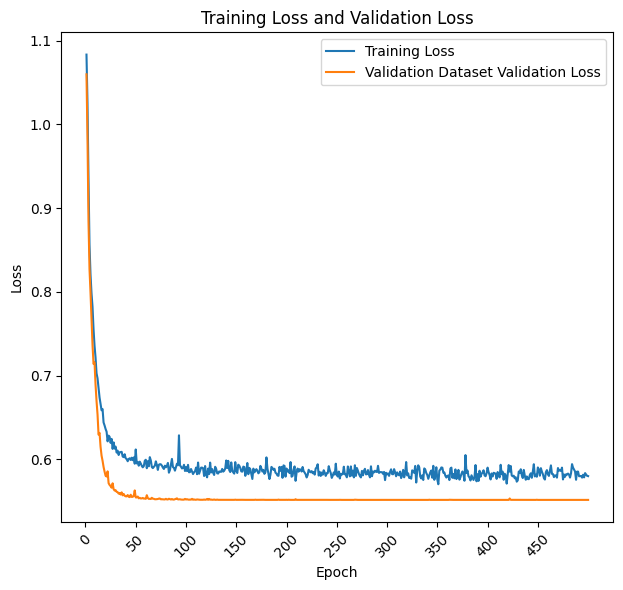

In [ ]:
#the test model, will not be used further, just for test
train_flower = IrisModel(num_inputs=4, num_hidden=10,num_hidden2=8, num_outputs=3)

num_epochs=500
loss_function_train = nn.CrossEntropyLoss()
optimizer_train = torch.optim.Adam(train_flower.parameters(), lr=0.001)

train_losses,validation_losses_2 = train_model(train_flower, data_loader, validation_loader, num_epochs,loss_function_train, optimizer_train)

plt.figure(figsize=(12, 6))

# Plot for training loss and validation dataset validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_losses_2, label='Validation Dataset Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.xticks(range(0, num_epochs, 50), rotation=45)

plt.tight_layout()
plt.show()


**Conclusion: From the plot we can see that there is no need to train model for more than 100 epoches ( to be more precise 50 is more than enough, but there is small fluctuations after it and a bit different results on a different machines, so the author decided to choose 100 for safety of prediction)**

#5. Neural network training

In [ ]:
#The true model that will be tested on 12-spieces validation set

model_flower = IrisModel(num_inputs=4, num_hidden=10,num_hidden2=8, num_outputs=3)


model_flower.train()

# recomended optimizer and loss function for clasification tasks (lecture theory about classificators)
loss_function_flower = nn.CrossEntropyLoss()
optimizer_flower = torch.optim.Adam(model_flower.parameters(), lr=0.001)

num_epochs=100

#The training using universal train function
x,y=train_model(model_flower, data_loader, validation_loader, num_epochs,loss_function_flower,optimizer_flower)



Epoch 1 		 Training Loss: 1.1007566598672716
Epoch 2 		 Training Loss: 1.0850613760569738
Epoch 3 		 Training Loss: 1.0700940910785917
Epoch 4 		 Training Loss: 1.052111027732728
Epoch 5 		 Training Loss: 1.0305547051959567
Epoch 6 		 Training Loss: 1.0056798751392062
Epoch 7 		 Training Loss: 0.9723086910588401
Epoch 8 		 Training Loss: 0.9238725862805806
Epoch 9 		 Training Loss: 0.868443523134504
Epoch 10 		 Training Loss: 0.8298911996304043
Epoch 11 		 Training Loss: 0.8042884762324984
Epoch 12 		 Training Loss: 0.7927172780036926
Epoch 13 		 Training Loss: 0.774365653594335
Epoch 14 		 Training Loss: 0.7617515079558842
Epoch 15 		 Training Loss: 0.755883107582728
Epoch 16 		 Training Loss: 0.7472760227937547
Epoch 17 		 Training Loss: 0.7349440455436707
Epoch 18 		 Training Loss: 0.7249701481962961
Epoch 19 		 Training Loss: 0.7167439555364942
Epoch 20 		 Training Loss: 0.7096007116257198
Epoch 21 		 Training Loss: 0.702434482082488
Epoch 22 		 Training Loss: 0.6988250088124048
Ep

# 6. Testing a neural network.
The results of all tests should be printed in an easy-to-understand format (12 lines, one for each example in the validation set), as well as an overall accuracy rating.
  Design example:

  Line 1: Classifier result: Iris-setosa; actual species: Iris-setosa, correct
  ...
  
  Line 12: classifier result: Iris-versicolor; real species: Iris-virginica, wrong
  
  Accuracy: 58% (7/12)

In [ ]:

model_flower.eval()

#The evaluation using universal validation function
validation_result = validate_model(model_flower, validation_loader,loss_function_flower)

data_table = []

# Data processing for table
for i in range(validation_result['total_predictions']):
    csv_line_num = i + 1
    vector_max = validation_result['vector'][i]
    predicted_species = validation_result['predicted_species'][i]
    real_species = validation_result['real_species'][i]
    is_correct = validation_result['is_correct'][i]
    data_table.append([csv_line_num+1, vector_max, predicted_species, real_species, 'True' if is_correct else 'False'])

headers = ['CSV_Line_Num', '        Vector', 'Classificator result', 'Real result', 'Correct']
print(tabulate(data_table, headers=headers, tablefmt='grid'))

# Overall validation loss and accuracy
print(f'\nValidation Loss: {validation_result["validation_loss"]:.4f}')
print(f'Validation Accuracy: {(validation_result["correct_predictions"] / validation_result["total_predictions"]) * 100:.2f}% or {validation_result["correct_predictions"]}/{validation_result["total_predictions"]}')

+----------------+------------------------+------------------------+-----------------+-----------+
|   CSV_Line_Num |         Vector         | Classificator result   | Real result     | Correct   |
+================+========================+========================+=================+===========+
|              2 | 0.9992, 0.0008, 0.0000 | Iris-setosa            | Iris-setosa     | True      |
+----------------+------------------------+------------------------+-----------------+-----------+
|              3 | 0.9995, 0.0005, 0.0000 | Iris-setosa            | Iris-setosa     | True      |
+----------------+------------------------+------------------------+-----------------+-----------+
|              4 | 0.9997, 0.0003, 0.0000 | Iris-setosa            | Iris-setosa     | True      |
+----------------+------------------------+------------------------+-----------------+-----------+
|              5 | 0.9994, 0.0006, 0.0000 | Iris-setosa            | Iris-setosa     | True      |
+---------

# EXTRA: Experiment - Which data may be classified incorrectly in *train dataset*?

This block repeats a code above for a test purpose


In [ ]:
model_flower.eval()

validation_result = validate_model(model_flower, data_loader_test, loss_function_flower)


#data_table = []

# for i in range(validation_result['total_predictions']):
#    csv_line_num = i + 1
#    vector_max = validation_result['vector'][i]
#   predicted_species = validation_result['predicted_species'][i]
#    real_species = validation_result['real_species'][i]
#   is_correct = validation_result['is_correct'][i]
#
#    data_table.append([csv_line_num+1, vector_max, predicted_species, real_species, 'True' if is_correct else 'False'])


#headers = ['CSV_Line_Num', '        Vector', 'Classificator result', 'Real result', 'Correct']
#print(tabulate(data_table, headers=headers, tablefmt='grid'))
# Print overall validation loss and accuracy

print(f'\nValidation Loss: {validation_result["validation_loss"]:.4f}')
print(f'Validation Accuracy: {(validation_result["correct_predictions"] / validation_result["total_predictions"]) * 100:.2f}% or {validation_result["correct_predictions"]}/{validation_result["total_predictions"]}')


Validation Loss: 0.5903
Validation Accuracy: 96.83% or 122/126


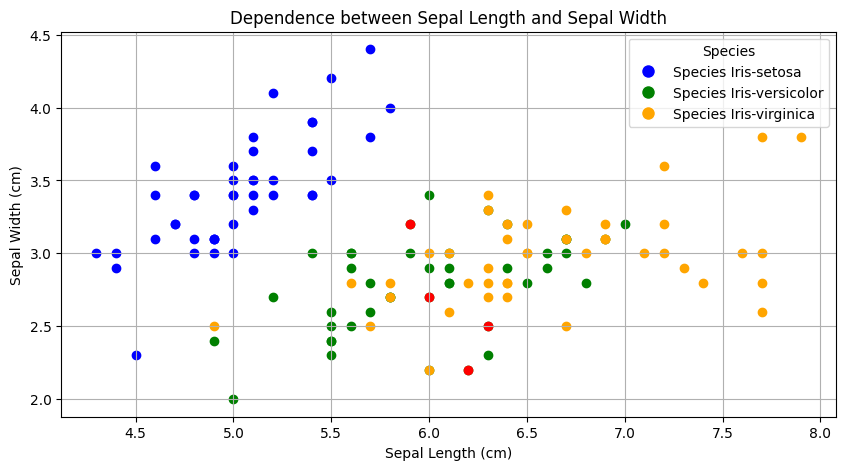

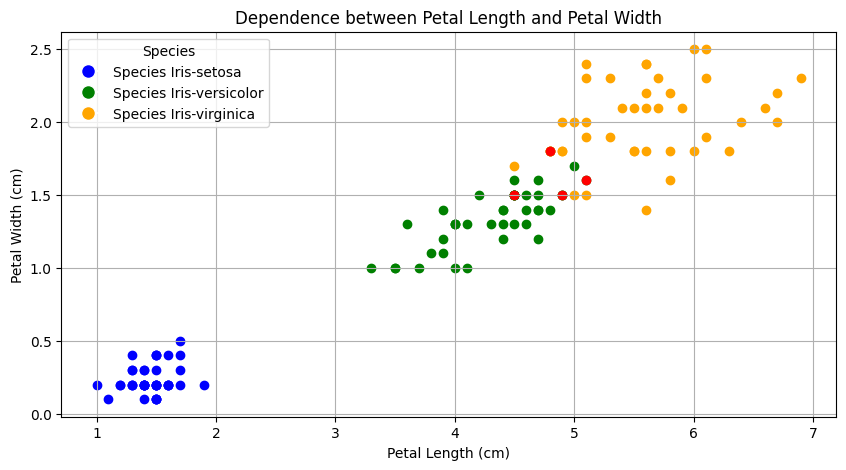

In [ ]:
# Loads the  original train dataset dataset and encode it. We cannot use Dataloader since it has tensors (and that way it is easier for this specific test)


data = pd.read_csv('Iris_train.csv') # change the name to Iris_Validate and do "Testing a neural network" block one more time to see plots for validation dataset
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values
is_correct = validation_result['is_correct']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Colors for each species
species_colors = ['blue', 'green', 'orange']
unique_labels_encoded = np.unique(labels_encoded) # ensures we dont have a long legend

# Plot for the dependence between the Sepal Length and Sepal Width
plt.figure(figsize=(10, 5))
for i in range(len(data)):
    species_label_encoded = labels_encoded[i]
    color = species_colors[int(species_label_encoded)]
    plt.scatter(features[i, 0], features[i, 1], color=color, label=f'Species {label_encoder.inverse_transform([species_label_encoded])[0]}')

# IMPORTANT
# Plots incorrectly classified points in RED
for i in range(len(data)):
    if not is_correct[i] and labels_encoded[i]:  # Only mark incorrectly classified points in red except for Iris-setosa
        plt.scatter(features[i, 0], features[i, 1], color='red')


plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Dependence between Sepal Length and Sepal Width')
# Create custom legend with correct colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Species {label_encoder.inverse_transform([i])[0]}',
                              markerfacecolor=species_colors[i], markersize=10) for i in unique_labels_encoded]
plt.legend(handles=legend_handles, title='Species')
plt.grid(True)
plt.show()


# Same plot but for different data and lables
# Plot for the dependence between the Petal Length and Petal Width
plt.figure(figsize=(10, 5))
for i in range(len(data)):
    species_label_encoded = labels_encoded[i]
    color = species_colors[int(species_label_encoded)]
    plt.scatter(features[i, 2], features[i, 3], color=color, label=f'Species {label_encoder.inverse_transform([species_label_encoded])[0]}')

for i in range(len(data)):
    if not is_correct[i] and labels_encoded[i] :
        plt.scatter(features[i, 2], features[i, 3], color='red')

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Dependence between Petal Length and Petal Width')


legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Species {label_encoder.inverse_transform([i])[0]}',
                              markerfacecolor=species_colors[i], markersize=10) for i in unique_labels_encoded]
plt.legend(handles=legend_handles, title='Species')
plt.grid(True)
plt.show()



**Here we can see that wrong data are usually data on the border of two types, which are difficult to distinguish**

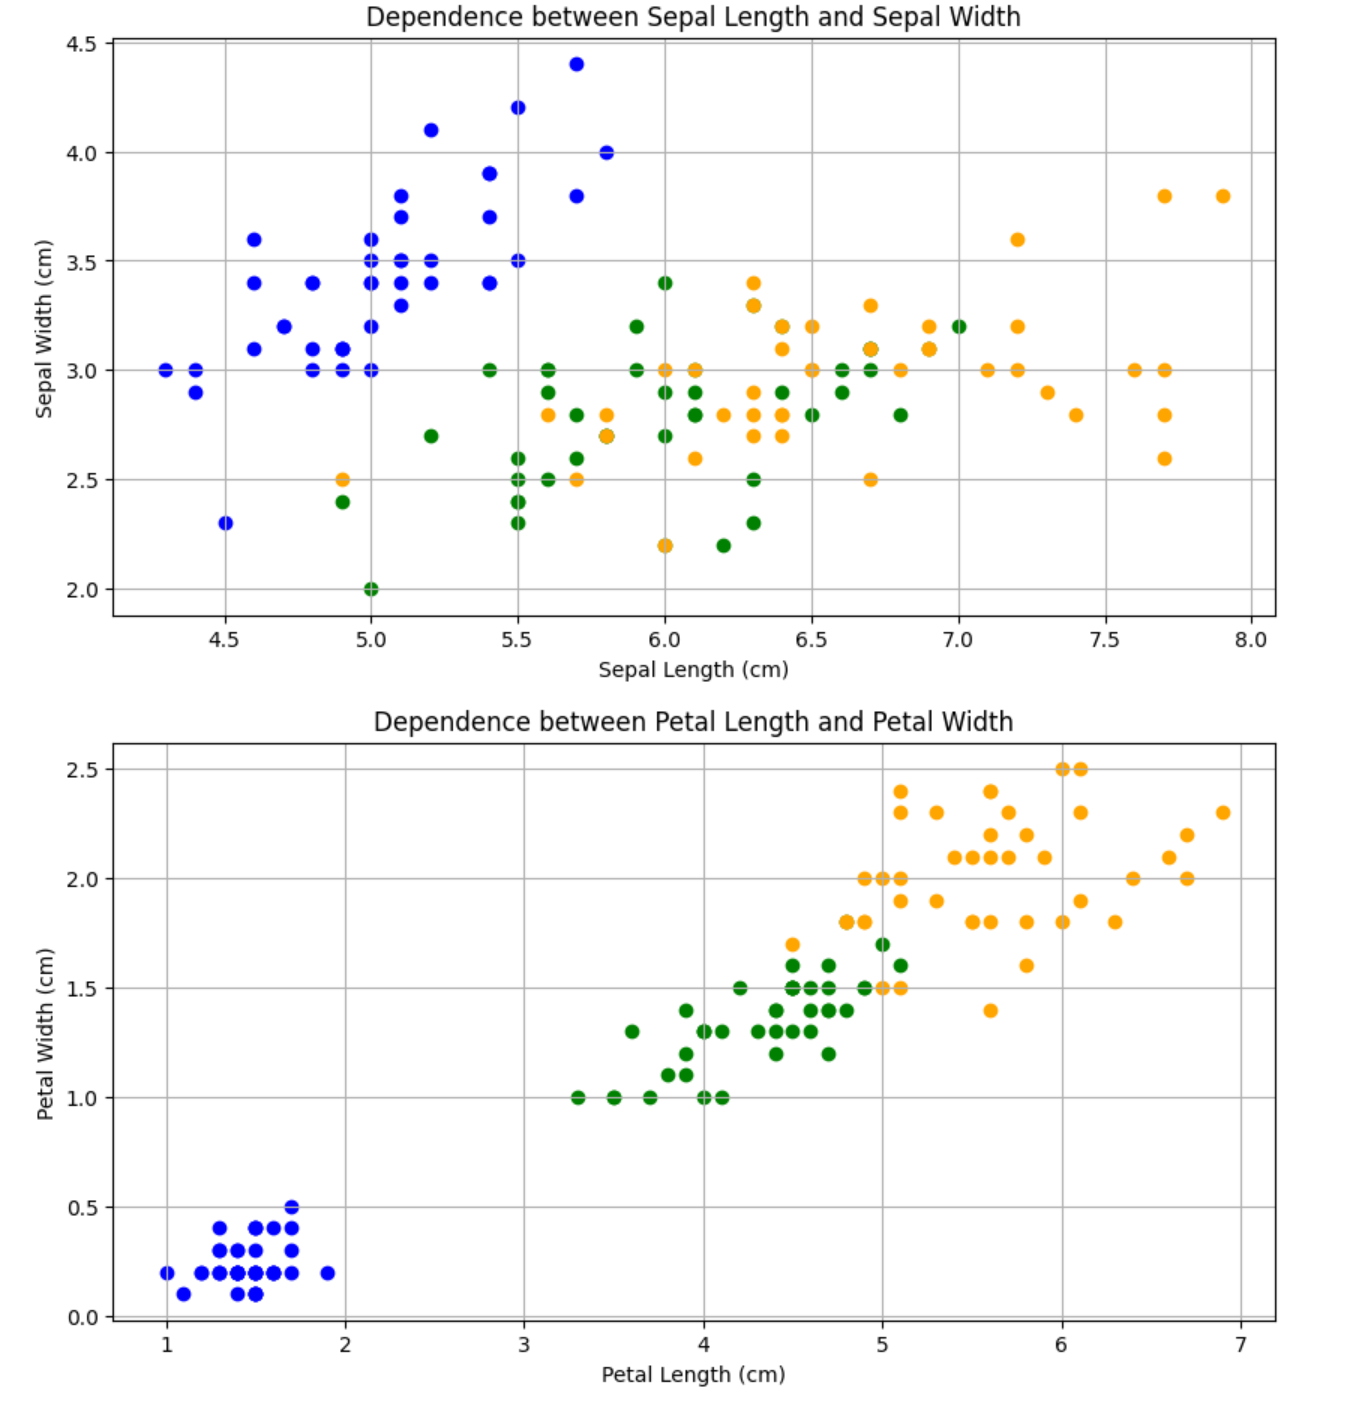